In [1]:
from qiskit import (QuantumCircuit, transpile, execute)
from qiskit import (QuantumRegister, ClassicalRegister, AncillaRegister)
from qiskit import BasicAer

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# We want to find 2,3,4, and 5 solutions for a 1024-item database to compare to the theoretical results.
# 1024 items require 10 qubits to represent the database, 9 qubits for the oracle workspace, and 10 classical bits to save the measurement
num_qubits_db = 10
num_ancillas = num_qubits_db - 1
total_qubits = num_qubits_db + num_ancillas

In [3]:
# Create initialization circuit with quantum, ancilla, and classical registers
qdb = QuantumRegister(num_qubits_db, "q")
anc = AncillaRegister(num_ancillas, "a")
clrq = ClassicalRegister(num_qubits_db, "c")
qc_init = QuantumCircuit(qdb,anc,clrq)

In [ ]:
# Initialization -- place all but ancillary qubits in superposition, though the last ancilla goes to the minus state.
qc_init.h(range(num_qubits_db))
qc_init.x(total_qubits - 1)
qc_init.h(total_qubits - 1)

qc_init.draw()

In [ ]:
# Oracle -- Marking the Solutions
# We have the option to mark 0-1023 as a solution.

grover_solutions = [3, 28, 580, 816, 1002]
grover_solutions_bin = [(10 - len(bin(index)[bin(index).rfind("b") + 1:]))  *  "0"
                       + bin(index)[bin(index).rfind("b") + 1:] for index in grover_solutions]

print(grover_solutions_bin)

In [ ]:
# We mark the solution based on symmetric X gates to all the qubits where the solution has a zero, followed by a multi-controlled NOT on the last qubit

# Separate Oracle CNOT circuit
oracle_control = QuantumCircuit(qdb,anc,clrq)

# Computation
oracle_control.ccx(0,1,num_qubits_db)
for i in range(2,num_qubits_db):
    oracle_control.ccx(i,i + num_ancillas - 1,i + num_ancillas)

# Un-computation
for i in [num_qubits_db + 1 - j for j in list(range(3,num_qubits_db))]:
    oracle_control.ccx(i,i + num_ancillas - 1,i + num_ancillas)
oracle_control.ccx(0,1,num_qubits_db)

oracle_control.draw(fold = 300)

In [ ]:
# Zero Locations
zero_loc_3 = [digit for digit in range(len(grover_solutions_bin[0])) if grover_solutions_bin[0][::-1][digit] == "0"]
zero_loc_28 = [digit for digit in range(len(grover_solutions_bin[0])) if grover_solutions_bin[1][::-1][digit] == "0"]
zero_loc_580 = [digit for digit in range(len(grover_solutions_bin[0])) if grover_solutions_bin[2][::-1][digit] == "0"]
zero_loc_816 = [digit for digit in range(len(grover_solutions_bin[0])) if grover_solutions_bin[3][::-1][digit] == "0"]
zero_loc_1002 = [digit for digit in range(len(grover_solutions_bin[0])) if grover_solutions_bin[4][::-1][digit] == "0"]

# solution 3
orac_3 = QuantumCircuit(qdb,anc,clrq)
orac_3.x(zero_loc_3)   
orac_3 = orac_3.compose(oracle_control)
orac_3.x(zero_loc_3)

# solution 28
orac_28 = QuantumCircuit(qdb,anc,clrq)
orac_28.x(zero_loc_28) 
orac_28 = orac_28.compose(oracle_control)
orac_28.x(zero_loc_28)

# solution 580
orac_580 = QuantumCircuit(qdb,anc,clrq)
orac_580.x(zero_loc_580)
orac_580 = orac_580.compose(oracle_control)
orac_580.x(zero_loc_580)

# solution 816
orac_816 = QuantumCircuit(qdb,anc,clrq)
orac_816.x(zero_loc_816)
orac_816 = orac_816.compose(oracle_control)
orac_816.x(zero_loc_816)

# solution 1002
orac_1002 = QuantumCircuit(qdb,anc,clrq)
orac_1002.x(zero_loc_1002)
orac_1002 = orac_1002.compose(oracle_control)
orac_1002.x(zero_loc_1002)

In [ ]:
# Here is a table with the chosen solutions to check the drawn circuit underneath it

<table style="margin-left:auto;margin-right:auto;">

<tr ALIGN=CENTER>
    <th>Number of Solutions</th>
    <th>Added Index</th>
    <th>Binary Representation</th>
</tr>
<tr ALIGN=CENTER>
    <td>Two</td>
    <td>
        3<BR>28<BR> 
    </td>
    <td>
        00 00 00 00 11<BR>00 00 01 11 00<BR>
    </td>
</tr>
<tr ALIGN=CENTER>
    <td>Three</td>
    <td>580</td>
    <td>10 01 00 01 00</td>
</tr>
<tr ALIGN=CENTER>
    <td>Four</td>
    <td>816</td>
    <td>11 00 11 00 00</td>
</tr>
<tr ALIGN=CENTER>
    <td>Five</td>
    <td>1002</td>
    <td>11 11 10 10 10</td>
</tr>

</table>


In [ ]:
orac_1002.draw(fold = 300)

In [ ]:
# For multiple solutions we combine the oracle's markings for each solution

orac_2_sol = orac_3.compose(orac_28) # two solutions: 3 and 28
orac_3_sol = orac_2_sol.compose(orac_580) # third additional solution: 580
orac_4_sol = orac_3_sol.compose(orac_816) # fourth additional solution: 816
orac_5_sol = orac_4_sol.compose(orac_1002) # fifth additional solution: 1002

In [ ]:
# For the two-solution search, the oracle encodes both 3 and 28 as a solution
orac_2_sol.draw(fold=900)

In [4]:
# Diffuser: Amplifying the state
# We apply the unitary that flips the states about the mean amplitude

qc_diff = QuantumCircuit(qdb,anc,clrq)

qc_diff.h(range(num_qubits_db))
qc_diff.x(range(num_qubits_db))
qc_diff.h(num_qubits_db - 1)

iterator = range(0,num_qubits_db,2)

# Computation of controlled NOTs
qc_diff.ccx(0,1,num_qubits_db)
for i in range(2,num_qubits_db-1):
    qc_diff.ccx(i,i + num_ancillas - 1,i + num_ancillas)

qc_diff.cx(num_qubits_db + num_ancillas - 2, num_qubits_db - 1)

# Un-computation
for i in [num_qubits_db + 1 - j for j in list(range(3,num_qubits_db))]:
    qc_diff.ccx(i,i + num_ancillas - 1,i + num_ancillas)
qc_diff.ccx(0,1,num_qubits_db)


qc_diff.h(num_qubits_db - 1)
qc_diff.x(range(num_qubits_db)) 
qc_diff.h(range(num_qubits_db))
qc_diff.barrier()

qc_diff.draw(fold=300)

┌───┐┌───┐                                                                                                                   ┌───┐┌───┐ ░ 
 q_0: ┤ H ├┤ X ├───────■────────────────────────────────────────────────────────────────────────────────────────────────────────■──┤ X ├┤ H ├─░─
      ├───┤├───┤       │                                                                                                        │  ├───┤├───┤ ░ 
 q_1: ┤ H ├┤ X ├───────■────────────────────────────────────────────────────────────────────────────────────────────────────────■──┤ X ├┤ H ├─░─
      ├───┤├───┤       │                                                                                                        │  ├───┤├───┤ ░ 
 q_2: ┤ H ├┤ X ├───────┼────■──────────────────────────────────────────────────────────────────────────────────────────────■────┼──┤ X ├┤ H ├─░─
      ├───┤├───┤       │    │                                                                                       ┌───┐  │    │  ├───┤└───┘ ░ 
 q_3: ┤ H ├┤ X ├───────┼────┼────■───────────────────────────────────────────────────────────────────────────────■──┤ X ├──┼────┼──┤ H ├──────░─
      ├───┤├───┤       │    │    │                                                                        ┌───┐  │  ├───┤  │    │  └───┘      ░ 
 q_4: ┤ H ├┤ X ├───────┼────┼────┼────■────────────────────────────────────────────────────────────────■──┤ X ├──┼──┤ H ├──┼────┼─────────────░─
      ├───┤├───┤       │    │    │    │                                                                │  ├───┤  │  ├───┤  │    │             ░ 
 q_5: ┤ H ├┤ X ├───────┼────┼────┼────┼────■──────────────────────────────────────────────────────■────┼──┤ X ├──┼──┤ H ├──┼────┼─────────────░─
      ├───┤├───┤       │    │    │    │    │                                               ┌───┐  │    │  ├───┤  │  └───┘  │    │             ░ 
 q_6: ┤ H ├┤ X ├───────┼────┼────┼────┼────┼────■───────────────────────────────────────■──┤ X ├──┼────┼──┤ H ├──┼─────────┼────┼─────────────░─
      ├───┤├───┤       │    │    │    │    │    │                                ┌───┐  │  ├───┤  │    │  └───┘  │         │    │             ░ 
 q_7: ┤ H ├┤ X ├───────┼────┼────┼────┼────┼────┼────■────────────────────────■──┤ X ├──┼──┤ H ├──┼────┼─────────┼─────────┼────┼─────────────░─
      ├───┤├───┤       │    │    │    │    │    │    │                 ┌───┐  │  ├───┤  │  └───┘  │    │         │         │    │             ░ 
 q_8: ┤ H ├┤ X ├───────┼────┼────┼────┼────┼────┼────┼────■─────────■──┤ X ├──┼──┤ H ├──┼─────────┼────┼─────────┼─────────┼────┼─────────────░─
      ├───┤├───┤┌───┐  │    │    │    │    │    │    │    │  ┌───┐  │  ├───┤  │  ├───┤  │  ┌───┐  │    │         │         │    │             ░ 
 q_9: ┤ H ├┤ X ├┤ H ├──┼────┼────┼────┼────┼────┼────┼────┼──┤ X ├──┼──┤ H ├──┼──┤ X ├──┼──┤ H ├──┼────┼─────────┼─────────┼────┼─────────────░─
      └───┘└───┘└───┘┌─┴─┐  │    │    │    │    │    │    │  └─┬─┘  │  └───┘  │  └───┘  │  └───┘  │    │         │         │  ┌─┴─┐           ░ 
 a_0: ───────────────┤ X ├──■────┼────┼────┼────┼────┼────┼────┼────┼─────────┼─────────┼─────────┼────┼─────────┼─────────■──┤ X ├───────────░─
                     └───┘┌─┴─┐  │    │    │    │    │    │    │    │         │         │         │    │         │       ┌─┴─┐└───┘           ░ 
 a_1: ────────────────────┤ X ├──■────┼────┼────┼────┼────┼────┼────┼─────────┼─────────┼─────────┼────┼─────────■───────┤ X ├────────────────░─
                          └───┘┌─┴─┐  │    │    │    │    │    │    │         │         │         │    │       ┌─┴─┐     └───┘                ░ 
 a_2: ─────────────────────────┤ X ├──■────┼────┼────┼────┼────┼────┼─────────┼─────────┼─────────┼────■───────┤ X ├──────────────────────────░─
                               └───┘┌─┴─┐  │    │    │    │    │    │         │         │         │  ┌─┴─┐     └───┘                          ░ 
 a_3: ──────────────────────────────┤ X ├──■────┼────┼────┼────┼────┼─────────┼─────────┼──

The number of iterations should be $\frac{\pi}{4} \sqrt{\frac{N}{M}}$ rounded to the nearest integer, where $N = 1024$ and $M$ is the number of solutions.

For 2, the number of iterations is $ \frac{\pi}{4}\sqrt{\frac{1024}{2}} = 18$.

For 3, the number of iterations is $ \frac{\pi}{4}\sqrt{\frac{1024}{3}} = 15$.

For 4, the number of iterations is $ \frac{\pi}{4}\sqrt{\frac{1024}{4}} = 13$.

For 5, the number of iterations is $ \frac{\pi}{4}\sqrt{\frac{1024}{5}} = 11$.

In [ ]:
# Experiments
# Create circuits for each number of solutions, with varying iterations

# Create storage dictionaries by number of solutions for the circuits
grover2_dict = {}
grover3_dict = {}
grover4_dict = {}
grover5_dict = {}

# Create dictionary keys
dict_keys = [str(iter+1) + "_iters" for iter in range(20)]

# Set the dictionary keys
for key in dict_keys:
    grover2_dict[key] = None
    grover3_dict[key] = None
    grover4_dict[key] = None
    grover5_dict[key] = None

In [ ]:
# 2 Solutions -- create oracle / diffuser circuit
base_grover2 = orac_2_sol.compose(qc_diff)

# Generate circuits with 1 grover iteration up to 20 iterations
for iter in range(20):

    tmp = qc_init.compose(base_grover2)

    for times in range(iter):

        tmp = tmp.compose(base_grover2)

    grover2_dict[dict_keys[iter]] = tmp

In [ ]:
# 3 Solutions -- create oracle / diffuser circuit
base_grover3 = orac_3_sol.compose(qc_diff)

# Generate circuits with 1 grover iteration up to 20 iterations
for iter in range(20):

    tmp = qc_init.compose(base_grover3)

    for times in range(iter):

        tmp = tmp.compose(base_grover3)

    grover3_dict[dict_keys[iter]] = tmp

In [ ]:
# 4 Solutions -- create oracle / diffuser circuit
base_grover4 = orac_4_sol.compose(qc_diff)

# Generate circuits with 1 grover iteration up to 20 iterations
for iter in range(20):

    tmp = qc_init.compose(base_grover4)

    for times in range(iter):

        tmp = tmp.compose(base_grover4)

    grover4_dict[dict_keys[iter]] = tmp

In [ ]:
# 5 Solutions -- create oracle / diffuser circuit
base_grover5 = orac_5_sol.compose(qc_diff)

# Generate circuits with 1 grover iteration up to 20 iterations
for iter in range(20):

    tmp = qc_init.compose(base_grover5)

    for times in range(iter):

        tmp = tmp.compose(base_grover5)

    grover5_dict[dict_keys[iter]] = tmp

In [ ]:
# Measurement applied to all circuits

grover2 = list(grover2_dict.values())
grover3 = list(grover3_dict.values())
grover4 = list(grover4_dict.values())
grover5 = list(grover5_dict.values())

[grover2[i].measure(range(num_qubits_db), range(num_qubits_db)) for i in range(len(grover2))]
[grover3[i].measure(range(num_qubits_db), range(num_qubits_db)) for i in range(len(grover3))]
[grover4[i].measure(range(num_qubits_db), range(num_qubits_db)) for i in range(len(grover4))]
[grover5[i].measure(range(num_qubits_db), range(num_qubits_db)) for i in range(len(grover5))]

In [ ]:
# Set up backend, shots for grover circuits
backend = BasicAer.get_backend("qasm_simulator")
shots = 20000

<table style="margin-left:auto;margin-right:auto;">

<tr ALIGN=CENTER>
    <th>Number of Solutions</th>
    <th>Added Index</th>
    <th>Binary Representation</th>
</tr>
<tr ALIGN=CENTER>
    <td>Two</td>
    <td>
        3<BR>28<BR> 
    </td>
    <td>
        00 00 00 00 11<BR>00 00 01 11 00<BR>
    </td>
</tr>
<tr ALIGN=CENTER>
    <td>Three</td>
    <td>580</td>
    <td>10 01 00 01 00</td>
</tr>
<tr ALIGN=CENTER>
    <td>Four</td>
    <td>816</td>
    <td>11 00 11 00 00</td>
</tr>
<tr ALIGN=CENTER>
    <td>Five</td>
    <td>1002</td>
    <td>11 11 10 10 10</td>
</tr>

</table>


In [ ]:
### DO NOT RUN ###

# Transpile, execute two-solution search (~10-minute runtime)
all_grover2 = transpile(grover2, backend)
all_grover2_jobs = execute(all_grover2, backend, shots=shots)
all_grover2_result = all_grover2_jobs.result()
all_grover2_counts = all_grover2_result.get_counts()


# Get counts for marked solutions (3 and 28), average their probability of occurrence
grover2_solution_counts = [np.array([all_grover2_counts[i]['0000000011'], all_grover2_counts[i]['0000011100']]) for i in range(len(all_grover2_counts))]
grover2_solution_ave_probs = [grover2_solution_counts[i].mean() / shots for i in range(len(grover2_solution_counts))]

# Do the same for non-solutions
grover2_nonsolution_counts = [shots - grover2_solution_counts[i].sum() for i in range(len(grover2_solution_counts))]
grover2_nonsolution_ave_probs = [grover2_nonsolution_counts[i] / ((1024-2) * shots) for i in range(len(grover2_nonsolution_counts))]


# Convert lists of solution / non-solution probabilities to numpy arrays and calculate the ratio
grover2_solution_ray = np.array([grover2_solution_ave_probs])
grover2_nonsolution_ray = np.array([grover2_nonsolution_ave_probs])
grover2_ratios = np.true_divide(grover2_solution_ray, grover2_nonsolution_ray)

In [ ]:
### DO NOT RUN ###

# Transpile, execute three-solution grover search (~13.5-minute runtime)
all_grover3 = transpile(grover3, backend)
all_grover3_jobs = execute(all_grover3, backend, shots=shots)
all_grover3_result = all_grover3_jobs.result()
all_grover3_counts = all_grover3_result.get_counts()


# Get counts for marked solutions (3, 28, 580), average their probability of occurrence
grover3_solution_counts = [np.array([all_grover3_counts[i]['0000000011'], all_grover3_counts[i]['0000011100'], all_grover3_counts[i]['1001000100']]) for i in range(len(all_grover3_counts))]
grover3_solution_ave_probs = [grover3_solution_counts[i].mean() / shots for i in range(len(grover3_solution_counts))]

# Do the same for non-solutions
grover3_nonsolution_counts = [shots - grover3_solution_counts[i].sum() for i in range(len(grover3_solution_counts))]
grover3_nonsolution_ave_probs = [grover3_nonsolution_counts[i] / ((1024-3) * shots) for i in range(len(grover3_nonsolution_counts))]


# Convert lists of solution / non-solution probabilities to numpy arrays and calculate the ratio
grover3_solution_ray = np.array([grover3_solution_ave_probs])
grover3_nonsolution_ray = np.array([grover3_nonsolution_ave_probs])
grover3_ratios = np.true_divide(grover3_solution_ray, grover3_nonsolution_ray)

In [ ]:
### DO NOT RUN ###

# Transpile, execute four-solution grover search (~17-minute runtime)
all_grover4 = transpile(grover4, backend)
all_grover4_jobs = execute(all_grover4, backend, shots=shots)
all_grover4_result = all_grover4_jobs.result()
all_grover4_counts = all_grover4_result.get_counts()


# Get counts for marked solutions (3, 28, 580, 816), average their probability of occurrence
grover4_solution_counts = [np.array([all_grover4_counts[i]['0000000011'], all_grover4_counts[i]['0000011100'], all_grover4_counts[i]['1001000100'], all_grover4_counts[i]['1100110000']]) for i in range(len(all_grover4_counts))]
grover4_solution_ave_probs = [grover4_solution_counts[i].mean() / shots for i in range(len(grover4_solution_counts))]

# Do the same for non-solutions
grover4_nonsolution_counts = [shots - grover4_solution_counts[i].sum() for i in range(len(grover4_solution_counts))]
grover4_nonsolution_ave_probs = [grover4_nonsolution_counts[i] / ((1024-4) * shots) for i in range(len(grover4_nonsolution_counts))]


# Convert lists of solution / non-solution probabilities to numpy arrays and calculate the ratio
grover4_solution_ray = np.array([grover4_solution_ave_probs])
grover4_nonsolution_ray = np.array([grover4_nonsolution_ave_probs])
grover4_ratios = np.true_divide(grover4_solution_ray, grover4_nonsolution_ray)

### Note to reader
There is no need to run the following code block. The results are saved in the blocks after the section "Saved Experiments Data"

In [ ]:
### DO NOT RUN ###

# Transpile, execute five-solution grover search (~20-minute runtime)
all_grover5 = transpile(grover5, backend)
all_grover5_jobs = execute(all_grover5, backend, shots=shots)
all_grover5_result = all_grover5_jobs.result()
all_grover5_counts = all_grover5_result.get_counts()


# Get counts for marked solutions (3, 28, 580, 816, 1002), average their probability of occurrence
grover5_solution_counts = [np.array([all_grover5_counts[i]['0000000011'], all_grover5_counts[i]['0000011100'], all_grover5_counts[i]['1001000100'], all_grover5_counts[i]['1100110000'], all_grover5_counts[i]['1111101010']]) for i in range(len(all_grover5_counts))]
grover5_solution_ave_probs = [grover5_solution_counts[i].mean() / shots for i in range(len(grover5_solution_counts))]

# Do the same for non-solutions
grover5_nonsolution_counts = [shots - grover5_solution_counts[i].sum() for i in range(len(grover5_solution_counts))]
grover5_nonsolution_ave_probs = [grover5_nonsolution_counts[i] / ((1024-5) * shots) for i in range(len(grover5_nonsolution_counts))]


# Convert lists of solution / non-solution probabilities to numpy arrays and calculate the ratio
grover5_solution_ray = np.array([grover5_solution_ave_probs])
grover5_nonsolution_ray = np.array([grover5_nonsolution_ave_probs])
grover5_ratios = np.true_divide(grover5_solution_ray, grover5_nonsolution_ray)

# Saved Experiments Data

In [2]:
# SAVED GROVER 2 EXPERIMENTS
grover2_ratios_copied = np.array([8.81079294e+00, 2.62726317e+01, 5.41092065e+01, 8.82026266e+01,
                                1.42954441e+02, 2.18010628e+02, 3.05424349e+02, 4.50158657e+02,
                                6.40549296e+02, 9.22782267e+02, 1.35498503e+03, 2.01432740e+03,
                                3.35143386e+03, 5.96145092e+03, 1.25413627e+04, 3.98842569e+04,
                                7.29489000e+05, 1.10575957e+05, 2.25589774e+04, 8.61400000e+03])


# SAVED GROVER 3 EXPERIMENTS
grover3_ratios_copied = np.array([9.28229493e+00, 2.61484772e+01, 5.37306200e+01, 9.73381344e+01,
                                1.59128559e+02, 2.47106614e+02, 3.83703117e+02, 5.96063237e+02,
                                9.40800991e+02, 1.59723190e+03, 3.06129918e+03, 7.45653570e+03,
                                2.52486391e+04,         np.inf, 3.01828356e+04, 6.60524490e+03,
                                3.05112988e+03, 1.60609694e+03, 9.44185758e+02, 5.88270578e+02])


# SAVED GROVER 4 EXPERIMENTS
grover4_ratios_copied = np.array([9.49538430e+00, 2.67835240e+01, 5.62792969e+01, 1.03171220e+02,
                                1.70567423e+02, 2.82861211e+02, 4.79024180e+02, 8.33116066e+02,
                                1.58283784e+03, 3.75758851e+03, 1.54857407e+04,         np.inf,
                                1.70919388e+04, 4.12268240e+03, 1.66229323e+03, 8.71076397e+02,
                                5.02463241e+02, 3.04333187e+02, 1.81905680e+02, 1.08015161e+02])


# SAVED GROVER 5 EXPERIMENTS
grover5_ratios_copied = np.array([9.03483891e+00, 2.56528259e+01, 5.73313986e+01, 1.07321288e+02,
                                1.85949474e+02, 3.40101788e+02, 6.34538132e+02, 1.28487787e+03,
                                3.21279681e+03, 1.87543395e+04, 1.56565431e+05, 6.38101422e+03,
                                1.88752889e+03, 8.41596255e+02, 4.43698014e+02, 2.50047010e+02,
                                1.40660407e+02, 7.51488092e+01, 3.92095988e+01, 1.68821873e+01])

/var/folders/l7/tvf40cgn2b91dp9tbv9n_nzh0000gn/T/ipykernel_1241/1641654799.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


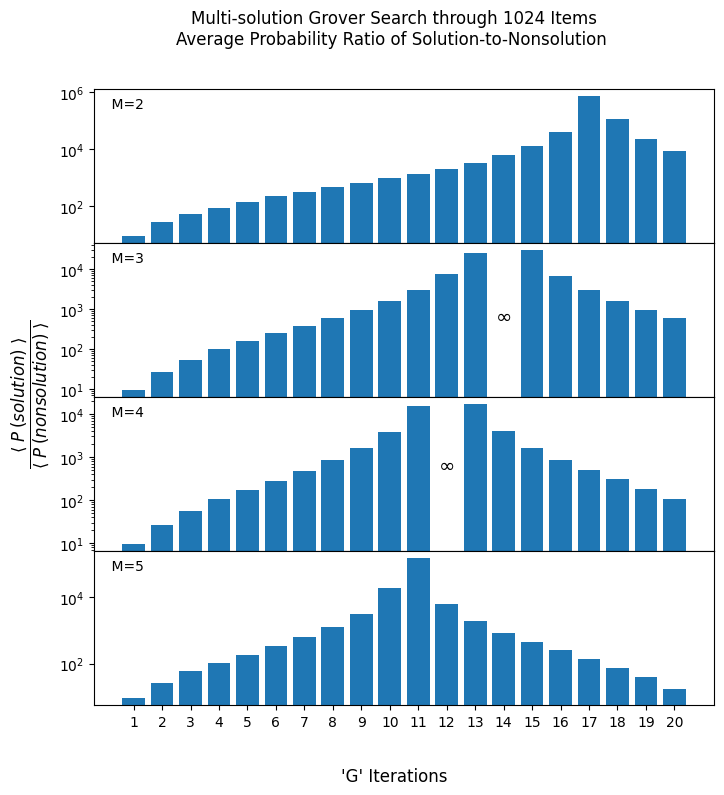

In [3]:
# Graph ratios vs. number of iterations using PyPlot

figure = plt.figure(1, figsize=[8,8])
figure.suptitle("Multi-solution Grover Search through 1024 Items\nAverage Probability Ratio of Solution-to-Nonsolution ", fontsize = "large")
figure.supxlabel("\'G\' Iterations")
figure.supylabel("$ \\dfrac{\\langle\\ P\\:(solution)\\ \\rangle}{\\langle\\ P\\:(nonsolution)\\ \\rangle} $")
gd = figure.add_gridspec(4, hspace=0)

two_sol_probs = figure.add_subplot(gd[0,0])
two_sol_probs.bar(np.arange(1,21,1), grover2_ratios_copied)
two_sol_probs.set_yscale("log")
two_sol_probs.set_xticks(np.arange(1,21,1))
two_sol_probs.set_xticklabels(np.arange(1,21,1))
two_sol_probs.set_title("    M=2", fontsize=10, loc='left', y=1, pad=-14)
two_sol_probs.label_outer()

three_sol_probs = figure.add_subplot(gd[1,0])
three_sol_probs.bar(np.arange(1,21,1), grover3_ratios_copied)
three_sol_probs.set_yscale("log")
three_sol_probs.set_xticks(np.arange(1,21,1))
three_sol_probs.set_xticklabels(np.arange(1,21,1))
three_sol_probs.set_title("    M=3", fontsize=10, loc='left', y=1, pad=-14)
three_sol_probs.sharex(two_sol_probs)
three_sol_probs.label_outer()

# annotate the infinity
inf_x3 = grover3_ratios_copied.argmax()+1-0.3
inf_y3 = 500
three_sol_probs.annotate('$\\infty$', xy=(inf_x3,inf_y3), xytext=(inf_x3,inf_y3), fontsize=14)

four_sol_probs = figure.add_subplot(gd[2,0])
four_sol_probs.bar(np.arange(1,21,1), grover4_ratios_copied)
four_sol_probs.set_yscale("log")
four_sol_probs.set_xticks(np.arange(1,21,1))
four_sol_probs.set_xticklabels(np.arange(1,21,1))
four_sol_probs.set_title("    M=4", fontsize=10, loc='left', y=1, pad=-14)
four_sol_probs.sharex(three_sol_probs)
four_sol_probs.label_outer()

# annotate the infinity
inf_x4 = grover4_ratios_copied.argmax()+1-0.3
inf_y4 = 500
four_sol_probs.annotate('$\\infty$', xy=(inf_x4,inf_y4), xytext=(inf_x4,inf_y4),fontsize=14)

five_sol_probs = figure.add_subplot(gd[3,0])
five_sol_probs.bar(np.arange(1,21,1), grover5_ratios_copied)
five_sol_probs.set_yscale("log")
five_sol_probs.set_xticks(np.arange(1,21,1))
five_sol_probs.set_xticklabels(np.arange(1,21,1))
five_sol_probs.set_title("    M=5", fontsize=10, loc='left', y=1, pad=-14)
five_sol_probs.sharex(four_sol_probs)
five_sol_probs.label_outer()

figure.show()


In [90]:
# Close plot
plt.close(1)

### Discussion

The above graph shows the "on average" ratio of the probability of getting a solution in the Grover search to the probability of not getting a solution.
Grover iterations increase the amplitude of the desired state according to 
$|\psi\rangle = \cos \left( \frac{\theta}{2} \right) |\alpha\rangle + \sin \left( \frac{\theta}{2} \right) |\beta \rangle$, where $\theta$ is the angle moving the general state toward the solution state after one iteration.
The number of iterations needed to reach the state with high probability is given by $R = \frac{\pi}{4}\sqrt{\frac{N}{M}}$.

For two solutions (top bar graph) the maximum ratio is at 17 iterations, one less than hypothesized since $R(N=1024,M=2) = 18$ when rounded. In fact, all maximum ratios except for the five-solution search occured at one less than the expected iterations, disagreeing with what some papers suggest - to round $R$ up if it is non-integer. The simulator could be the culprit. Testing with other simulators would verify whether to round up or down. 
For the three- and four-solution searches, the ratio reached infinity at 14 and 12 iterations, respectively. This is due to the division of zero as there were no occurrences of a non-solutions in those cases.

Overall, the average probability of getting a solution, according to the graphs, can be greater than four orders of magnitude than the probability of getting a non-solution. This is reassuring for the quantum search algorithm.